In [14]:
using CSV, DataFrames, Distributions, Dates, Gadfly, GLM, Statistics, Random, Plots, MultivariateStats, StatsBase, LinearAlgebra

# Utilisation des fichiers CSV

On devrait surement faire le split 80/20 juste avant la création du modèle et appeler toutes nos fonction d'encoding sur la variables full_train et non 2 fois sur train et valid

En raison du score basé sur le RMSLE, nous avons conclu que l'entrainement du modèle sur les bateau ayant des prix inférieur à 100k$ était d'avantage performant

In [72]:
full_train = CSV.read("Data/train.csv", DataFrame)
test = CSV.read("Data/test.csv", DataFrame)


Random.seed!(3302)

train_id = sample(1:nrow(full_train), round(Int, .8nrow(full_train)), ordered=true, replace=false)
valid_id = setdiff(1:nrow(full_train), train_id)


train = full_train[train_id,:]
valid = full_train[valid_id,:];


# 1. Compréhension de la métrique RMSLE

## Aperçu de RMSLE

La racine carrée de l'erreur quadratique moyenne logarithmique (RMSLE) est une mesure de la précision des valeurs prédites. Cependant elle se distincue de la somme des erreurs au carré (SSE) par le fait qu'elle pénalise les erreurs de prédiction des valeurs les plus élevées plus que les erreurs de prédiction des valeurs les plus faibles. Par conséquent, nous nos devrons s'assurer que, dans le cas ou notre modèle voit des valeurs supérieurs a sont ensemble d'entrainement, nous essayerons que notre preédiction soit inférieu et non supérieur a la valeur réelle afin de minimiser la pénalité. 

En effet cette approche est différente de celle aborde tout au long de la regression linéaire et bayesienne sachanque que nous voulions habutuellement que notre modèle pénalise équitablement pour les valeurs supérieurs et inférieurs aux valeurs prédictes.

C'est donc pour cette raison que vous aller régulièrement nous voir couper des valeurs réelles de notre ensemble d'entrainement qui semble être majoritairement supérieur a la moyenne observé. De cette façon, nous minimiserons les probabilités que notre modèle de prediction prédisent des valeurs supérieurs a la réalité sachant qu'il n'a jamais vu de telles valeurs lors de l'entrainement. 

In [ ]:
function rmsle(predictions::Vector{Int64}, actual::Vector{Int64})
    if length(predictions) != length(actual)
        throw(ArgumentError("Les vecteurs de prédictions et de valeurs réelles doivent avoir la même longueur"))
    end
    
    n = length(predictions)
    sum_squared_log_errors = 0
    
    for i in 1:n
        sum_squared_log_errors += (log(predictions[i] + 1) - log(actual[i] + 1))^2
    end
    
    rmsle_score = sqrt(sum_squared_log_errors / n)
    return rmsle_score
end

# 2. Exploration des données


## 2.1 Matrice de correlation entre les variables

Nous avons décidé de faire une matrice de corrélation entre toutes variables du set de données afin d'avoir une idée générale de la puissance de corrélation. Cependant, il est important de noter que cette matrice ne définit que les relations 1:1 entres les variables, par conséquent nous devrons faire des analyses plus poussées afin de comprendre les lien entres plusieurs variables combinées. 

Toutefois, il est possible de remarquer que les variables les plus corrélées avec la variable cible sont : Longueur, Poids et Puissance_Moteur

In [ ]:
data = deepcopy(full_train)
data = dropmissing(data)


cols = [:Année, :Largeur, :Longueur, :Poids, :Nombre_Moteurs, :Puissance_Moteur, :Mois_Vente, :Année_Vente, :Prix]  # define subset
M = cor(Matrix(data[!,cols]))       # correlation matrix

# PLOT
(n,m) = size(M)
heatmap(M, fc=cgrad([:white,:dodgerblue4]), xticks=(1:m,cols), xrot=90, yticks=(1:m,cols), yflip=true)
annotate!([(j, i, text(round(M[i,j],digits=3), 8,"Computer Modern",:black)) for i in 1:n for j in 1:m])

## 2.2 Présentation des données manquantes

Il est possible de remarquer que les colonnes Largeur, Poids, Carburant, Puissance_moteur ainsi que Type_Moteur possèdent des données manquantes. Nous allons donc devoir les traiter si nous voulons les utiliser pour l'entrainement de notre modèle.

In [ ]:
missing_counts = mapcols(x -> count(ismissing, x), full_train)

## 2.3 Variables explicatives

### Type

In [ ]:
set_default_plot_size(12cm, 10cm)
Gadfly.plot(train, x=:Type, y=:Prix, Geom.boxplot, Guide.title("Prix selon le type d'embarcation"), Scale.y_log10)

On remarque que les bateaux alimentés peuvent atteindre des prix très élevés, et que les bateux à voile peuvent aussi parfois être vendus très chers (plus de 1M de dollars) tandis que les bateux non alimentés n'atteignent jamais des prix exorbitants. Cela est sensé si l'on se dit que les bateux non alimentés s'agissent probablement de plus petites petites embarcations comme des kayaks, entre autres.

### Classe

#### Prix de vente en fonction de la classe pour les embarcations motorisées

In [ ]:
set_default_plot_size(30cm, 10cm)
emb_motorises = filter(row -> row.Type == "power", train)
Gadfly.plot(emb_motorises, x=:Classe, y=:Prix, Geom.boxplot, Guide.title("Prix selon la classe d'embarcation motorisée"), Scale.y_log10)

Comme on peut le voir il existe beaucoup de différentes classes pour chaque type d'embarcation. Pour plusieurs d'entre-elles, les prix semblent rester dans des ordres similaires. Cependant, comme on peut le voir par le précédent graphique, certaines classes peuvent atteindre des prix plus élevés et certaines semblent même en moyenne se vendre considérablement plus cher que d'autres, notamment les classe "power-mega" et "power-passenger". D'autres ont des prix plus bas en moyenne comme "power-util".

In [ ]:
df = combine(groupby(emb_motorises, :Classe), nrow => :NbOccurrences)

#### Prix de vente en fonction de la classe pour les embarcations à voile

In [ ]:
set_default_plot_size(20cm, 10cm)
emb_voile = filter(row -> row.Type == "sail", train)
Gadfly.plot(emb_voile, x=:Classe, y=:Prix, Geom.boxplot, Guide.title("Prix selon la classe d'embarcation à voile"), Scale.y_log10)

Pour ce qui est des bateaux à voile, les embarcations de la classe "sail-catamaran" se démarquent selon leur prix de vente qui semble être considérablement plus élevé.

In [ ]:
df = combine(groupby(emb_voile, :Classe), nrow => :NbOccurrences)

#### Prix de vente en fonction de la classe pour les embarcations non motorisées

In [ ]:
set_default_plot_size(20cm, 10cm)
emb_non_motorises = filter(row -> row.Type == "unpowered", train)
Gadfly.plot(emb_non_motorises, x=:Classe, y=:Prix, Geom.boxplot, Guide.title("Prix selon la classe d'embarcation non-motorisée"))

Comme on peut le voir, il semble que les embarcations "unpowered-tender" semblent être celles qui se vendent plus cher parmi les bateaux non motorisés.

In [ ]:
df = combine(groupby(emb_non_motorises, :Classe), nrow => :NbOccurrences)

Bref la classe d'une embarcation peut certainement donner de la bonne information pour estimer son prix. Cependant, certaines classes sont plus communes dans les données que d'autres et offrent donc de meilleures estimations, tandis que d'autres sont plus rares et risquent d'être moins pertinents. De plus, il est très possible que de nouvelles données ajoutent de nouvelles classes non présentes dans celles d'entraînement.

### Fabricant

In [ ]:
fabricants = combine(groupby(train, :Fabricant), nrow => :NbOccurrences, :Prix => mean => Symbol("Prix_Moyen"))
dropmissing!(fabricants)

En regroupant les données selon le fabricant, on remarque qu'il y a plus de 600 de ces derniers. Pour mieux se donner une idée de l'impact que le fabricant a sur le prix de vente final on peut donc décider de jeter un coup d'oeil aux fabricants dont le prix de vente est en moyenne le plus élevé et ceux dont le prix de vente est en moyenne le plus bas.

In [ ]:
fabricants[partialsortperm(fabricants.Prix_Moyen, 1:10, rev=true), :]

In [ ]:
fabricants[partialsortperm(fabricants.Prix_Moyen, 1:10), :]

Comme on peut le voir, pour certains fabricants, le prix de vente moyen de leur embarcations est très bas (entre 500 et 2000 dollars) tandis que pour d'autres, le prix est assez exorbitant (entre 1 et 2.75M de dollars). Le fabricant d'une embarcation peut donc être une information très utile pour déterminer son prix. Cependant, il y a énormément de divers fabricants et il n'y a aucune assurance que de nouvelles données n'introduisent pas de nouveux fabricants dont la moyenne de prix de vente est inconnue.

### Modèle

In [56]:
unique_modèle_train = unique(train[:, :Modèle]); 
println("Number of unique categories: ", length(unique_modèle_train))
unique_modèle_valid = unique(valid[:, :Modèle]);
missing_modèles = setdiff(unique_modèle_valid, unique_modèle_train);
println("Initially missing " * string(length(missing_modèles)) * " modèles in the training set")

Number of unique categories: 4821
Initially missing 847 modèles in the training set


Il existe énormément de modèles de bateau différents (5668) et ceux-ci se répètent très peu, nous avons ainsi des doutes sur la pertinence de cette colonne de données. De plus, cette colonne est présentement inutilisation dans un modèle. Il faudra encoder un algorithme one-hot.

In [ ]:
exploration = dropmissing(train, :Modèle)
unique_categories = unique(skipmissing(exploration[:, :Modèle]))
occurences = [sum(skipmissing(exploration[:, :Modèle]) .== category) for category in unique_categories]
occurences = DataFrame(category = unique_categories, occurences = occurences)
occurences = occurences[occurences.occurences .> 1, :]

function calculate_statistics(category)
    subset_data = exploration[exploration[:, :Modèle] .== category, :Prix]
    min_prix = minimum(subset_data)
    max_prix = maximum(subset_data)
    mean_prix = mean(skipmissing(subset_data))
    return (min_prix = min_prix, max_prix = max_prix, mean_prix = mean_prix)
end

prix_statistics = DataFrame([calculate_statistics(category) for category in occurences[:, :category]])
occurences = hcat(occurences, prix_statistics)

Ce tableau nous démontre que le modèle est un excellant prédicteur de prix. Le seul désavantage à celui-ci est qu'il en existe beaucoup. De ce fait, plusieurs modèles se retrouvent dans l'ensemble de test, mais ne sont jamais vus dans l'ensemble d'entrainement.

Remplacement des variables "Missing" par une autre catégorie

In [73]:
replaceValue = "Autre"
train[!, :Modèle] = coalesce.(train[!, :Modèle], replaceValue);
valid[!, :Modèle] = coalesce.(valid[!, :Modèle], replaceValue);

Le code suivant sert à associer à chaque modèle connu à un intervalle de prix. Pour se faire nous utilisons la moyenne qui est plus performante que la médiane en raison de la quantité imposante de modèles observés uniquement 2 fois dans l'ensemble d'entrainement.

In [74]:
price_ranges = [
    ("Under5k", 0, 5000),
    ("5kto10k", 5001, 10000),
    ("10kto15k", 10001, 15000),
    ("15kto20k", 15001, 20000),
    ("20kto25k", 20001, 25000),
    ("25kto30k", 25001, 30000),
    ("30kto35k", 30001, 35000),
    ("35kto40k", 35001, 40000),
    ("40kto45k", 40001, 45000),
    ("45kto50k", 45001, 50000),
    ("50kto55k", 50001, 55000),
    ("55kto60k", 55001, 60000),
    ("60kto65k", 60001, 65000),
    ("65kto70k", 65001, 70000),
    ("70kto75k", 70001, 75000),
    ("75kto80k", 75001, 80000),
    ("80kto85k", 80001, 85000),
    ("85kto90k", 85001, 90000),
    ("90kto95k", 90001, 95000),
    ("95kto100k", 95001, 100000)
]

# Function to assign category based on price
function assign_category(price)
    for (category, min_price, max_price) in price_ranges
        if price >= min_price && price <= max_price
            return category
        end
    end
end


assign_category (generic function with 1 method)

La fonction suivant sert à encoder selon one-hot les tranches de prix prédéfinies plus haut.

In [63]:
function encode_category_Model!(df::DataFrame, category_mapping::DataFrame, model_col::Symbol)
    categories = unique(category_mapping.Category)
    for category in categories
        df[!, Symbol("is", category)] = zeros(Int, nrow(df))
    end

    missing_modèle_counter = 0
    for i in 1:nrow(df)
        model = df[i, model_col]
        matching_rows = filter(row -> row.Model == model, category_mapping)
        
        if isempty(matching_rows)
            category = "20kto25k" #0.6455753480203078 #maximise le score rmsle
            missing_modèle_counter += 1
        else
            category = matching_rows[1, :Category]
        end
    
        df[i, Symbol("is", category)] = 1
    end
    println("Missing modèles count: ", missing_modèle_counter)
end


encode_category_Model! (generic function with 1 method)

#### Test #1 : Tester avec le modèle. Les tests suivant (1-5) avec le rmsle sont pertinant sont d'évaluer la meilleure utilisation de la variable modèle. Les vrais test pour la prédiction du prix se trouve uniquement à vers la fin du rapport

In [ ]:
# Grouping by boat model and calculating mean price
merged_df = combine(groupby(train, :Modèle), :Prix => mean => :Mean_Price)
# Apply function to assign category to each model
model_mapping = DataFrame(Model = merged_df.Modèle, Category = map(assign_category, merged_df.Mean_Price))
# One Hot encoding
encode_category_Model!(train, model_mapping, :Modèle)
encode_category_Model!(valid, model_mapping, :Modèle)

model_Modèle = lm(@formula(Prix ~ isUnder5k + is5kto10k + is10kto15k 
                        + is15kto20k + is20kto25k + is25kto30k 
                        + is30kto35k + is35kto40k + is40kto45k
                        + is45kto50k + is50kto55k + is55kto60k 
                        + is60kto65k + is65kto70k + is70kto75k 
                        + is75kto80k + is80kto85k + is85kto90k 
                        + is90kto95k + is95kto100k), train);

In [ ]:
valid_prediction = predict(model_Modèle, valid)
mean_prediction = mean(valid_prediction)
valid_prediction = coalesce.(valid_prediction, mean_prediction)
v = Int.(round.(valid_prediction, digits=0))
score = rmsle(v, valid.Prix)

Essayons d'améliorer le modèle en réduisant le nombre de modèles jamais vus. Pour ce faire, tentons de trouver des noms de modèles très similaires

In [ ]:
unique_data_modèles = unique(train[!, :Modèle])
regex_pattern = r"\D+"
# Function to extract the non-numeric part of the 'Modèle' string
function extract_model_name(model)
    match_result = match(regex_pattern, replace(lowercase(string(model)), r"\s+" => ""))
    return match_result === nothing ? "other" : match_result.match
end
# Apply the function to create a new column 'Modèle_New' in the train DataFrame
train[!, :Modèle_New] = coalesce.(extract_model_name.(train[!, :Modèle]), "Other")
valid[!, :Modèle_New] = coalesce.(extract_model_name.(valid[!, :Modèle]), "Other")

# Extract unique values of 'Modèle_New' from both datasets
unique_data_modèles = unique(train[!, :Modèle_New])
println("Number of unique modèle in train: ", length(unique_data_modèles))
unique_valid_modèles = unique(valid[!, :Modèle_New])
println("Number of unique modèle in valid: ", length(unique_valid_modèles))
diff_modèles = setdiff(unique_valid_modèles, unique_data_modèles)
println("Now missing " * string(length(diff_modèles)) * " modèles in the training set")

De cette façon, c'est à dire en oubliant les majuscules et les chiffres, nous passons de 775 à 245 modèles présents dans l'ensemble de validation, mais manquants dans l'ensemble d'entrainement.

#### Test #2 : Testons avec le modèle modifié (suppressions caractères spéciaux et chiffres) 

In [ ]:
merged_df = combine(groupby(train, :Modèle_New), :Prix => mean => :Mean_Price)
model_mapping = DataFrame(Model = merged_df.Modèle_New, Category = map(assign_category, merged_df.Mean_Price))# One Hot encoding
encode_category_Model!(train, model_mapping, :Modèle_New)
encode_category_Model!(valid, model_mapping, :Modèle_New)
model_Modèle = lm(@formula(Prix ~ isUnder5k + is5kto10k + is10kto15k 
                        + is15kto20k + is20kto25k + is25kto30k 
                        + is30kto35k + is35kto40k + is40kto45k
                        + is45kto50k + is50kto55k + is55kto60k 
                        + is60kto65k + is65kto70k + is70kto75k 
                        + is75kto80k + is80kto85k + is85kto90k 
                        + is90kto95k + is95kto100k), train);

In [ ]:
valid_prediction = predict(model_Modèle, valid)
mean_prediction = mean(valid_prediction)
valid_prediction = coalesce.(valid_prediction, mean_prediction)
v = Int.(round.(valid_prediction, digits=0))
score = rmsle(v, valid.Prix)

Malgré le nombre de modèle connus augmenté, le score rmlse baisse quelque peu.

Essayons de baisser encore plus le nombre de modèles inconnus en important une librairie permettant de calculer la ressemblance entre les string.

In [ ]:
using StringDistances

threshold = 0.2
mapping = Dict{String, String}()

for modèle_valid in unique_valid_modèles
    best_match = ""
    best_similarity = 0.0
    
    for modèle_train in unique_data_modèles
        similarity = compare(modèle_valid, modèle_train, StringDistances.Levenshtein())
        
        if similarity > threshold && similarity > best_similarity
            best_match = modèle_train
            best_similarity = similarity
        end
    end
    
    if best_match != ""
        mapping[modèle_valid] = best_match
    end
end


In [ ]:
filtered_dict = Dict(key => value for (key, value) in mapping if key != value)
println("Number of mappings: ", length(filtered_dict))

for (key, value) in filtered_dict
    println("$key => $value ")
    println(train[train.Modèle_New .== value, :])
    println(valid[valid.Modèle_New .== key, :])
    println()   
    println()
    println()
end

L'on remarque que le modèle "centerconsole" possède de nombreux fabricants différents...
De plus, l'âge semble avoir un influence importante sur le prix (voir probass/pro-vbass)

Oberservons si les manipulations fonctionnent.

In [ ]:
replace_with_mapping(value) = get(mapping, value, value)
valid[!, :Modèle_New2] .= replace_with_mapping.(valid[!, :Modèle_New]);
first(valid, 1)

In [ ]:
unique_data_modèles = unique(train[!, :Modèle_New])
println("Number of unique modèle in train: ", length(unique_data_modèles))
unique_valid_modèles = unique(valid[!, :Modèle_New2])
println("Number of unique modèle in valid: ", length(unique_valid_modèles))
diff_modèles = setdiff(unique_valid_modèles, unique_data_modèles)
println("Now missing " * string(length(diff_modèles)) * " modèles in the training set")

En raison du mapping avec le best match, aucun modèle n'est maintenant manquant. En échange, le nombre de modèles uniques de l'ensemble de test est passé de 793 à 658.

#### Test #3 : Test avec modèle simplifier et NLP

In [ ]:
merged_df = combine(groupby(train, :Modèle_New), :Prix => mean => :Mean_Price)
model_mapping = DataFrame(Model = merged_df.Modèle_New, Category = map(assign_category, merged_df.Mean_Price))# One Hot encoding
encode_category_Model!(train, model_mapping, :Modèle_New)
encode_category_Model!(valid, model_mapping, :Modèle_New2)
model_Modèle = lm(@formula(Prix ~ isUnder5k + is5kto10k + is10kto15k 
                        + is15kto20k + is20kto25k + is25kto30k 
                        + is30kto35k + is35kto40k + is40kto45k
                        + is45kto50k + is50kto55k + is55kto60k 
                        + is60kto65k + is65kto70k + is70kto75k 
                        + is75kto80k + is80kto85k + is85kto90k 
                        + is90kto95k + is95kto100k), train);

In [ ]:
valid_prediction = predict(model_Modèle, valid)
mean_prediction = mean(valid_prediction)
valid_prediction = coalesce.(valid_prediction, mean_prediction)
v = Int.(round.(valid_prediction, digits=0))
score = rmsle(v, valid.Prix)

Testons une approche similaire aux 2 dernières, mais en jumelant le modèle et le fabricant.

In [ ]:
#Create a new column 'Fab_Model" in the train and valid DataFrame
train[!, :Fab_Model] = train[!, :Fabricant] .* "_" .* train[!, :Modèle]
valid[!, :Fab_Model] = valid[!, :Fabricant] .* "_" .* valid[!, :Modèle];

#### Test #4 : test avec la nouvelle colonne : FabModèle

In [ ]:
merged_df = combine(groupby(train, :Fab_Model), :Prix => mean => :Mean_Price)
model_mapping = DataFrame(Model = merged_df.Fab_Model, Category = map(assign_category, merged_df.Mean_Price))# One Hot encoding
encode_category_Model!(train, model_mapping, :Fab_Model)
encode_category_Model!(valid, model_mapping, :Fab_Model)
model_Modèle = lm(@formula(Prix ~ isUnder5k + is5kto10k + is10kto15k 
                        + is15kto20k + is20kto25k + is25kto30k 
                        + is30kto35k + is35kto40k + is40kto45k
                        + is45kto50k + is50kto55k + is55kto60k 
                        + is60kto65k + is65kto70k + is70kto75k 
                        + is75kto80k + is80kto85k + is85kto90k 
                        + is90kto95k + is95kto100k), train);

In [ ]:
valid_prediction = predict(model_Modèle, valid)
mean_prediction = mean(valid_prediction)
valid_prediction = coalesce.(valid_prediction, mean_prediction)
v = Int.(round.(valid_prediction, digits=0))
score = rmsle(v, valid.Prix)

#### Test #5 : Test avec la nouvelle colonne FabModele et en réduisant avec un regex les strings

In [ ]:
unique_data_modèles = unique(train[!, :Fab_Model])
regex_pattern = r"\D+"
# Function to extract the non-numeric part of the 'Modèle' string
function extract_model_name(model)
    match_result = match(regex_pattern, replace(lowercase(string(model)), r"\s+" => ""))
    return match_result === nothing ? "other" : match_result.match
end
# Apply the function to create a new column 'Modèle_New' in the train DataFrame
train[!, :Fab_Model] = coalesce.(extract_model_name.(train[!, :Fab_Model]), "Other")
valid[!, :Fab_Model] = coalesce.(extract_model_name.(valid[!, :Fab_Model]), "Other");

In [ ]:
merged_df = combine(groupby(train, :Fab_Model), :Prix => mean => :Mean_Price)
model_mapping = DataFrame(Model = merged_df.Fab_Model, Category = map(assign_category, merged_df.Mean_Price))# One Hot encoding
encode_category_Model!(train, model_mapping, :Fab_Model)
encode_category_Model!(valid, model_mapping, :Fab_Model)
model_Modèle = lm(@formula(Prix ~ isUnder5k + is5kto10k + is10kto15k 
                        + is15kto20k + is20kto25k + is25kto30k 
                        + is30kto35k + is35kto40k + is40kto45k
                        + is45kto50k + is50kto55k + is55kto60k 
                        + is60kto65k + is65kto70k + is70kto75k 
                        + is75kto80k + is80kto85k + is85kto90k 
                        + is90kto95k + is95kto100k), train);

In [ ]:
valid_prediction = predict(model_Modèle, valid)
mean_prediction = mean(valid_prediction)
valid_prediction = coalesce.(valid_prediction, mean_prediction)
v = Int.(round.(valid_prediction, digits=0))
score = rmsle(v, valid.Prix)

### Année et années de vente

In [ ]:
function encode_age(df::DataFrame)
    df[!, :Age] = df[!, :Année_Vente] .- df[!, :Année]
    logAge = ifelse.(df[!, :Age] .<= 0, 1, df[!, :Age])
    #logAge
    df[!, :LogAge] = (log.(logAge))
end

encode_age(full_train);

full_train;

In [ ]:
#Plots.plot(full_train.Age, x=:Age, y=:Prix, Geom.point)

set_default_plot_size(40cm, 20cm)

plot1 = Gadfly.plot(full_train, x=:Age, y=:Prix, color=:Type, Geom.point)
plot2 = Gadfly.plot(full_train, x=:LogAge, y=:Prix, color=:Type, Geom.point)

hstack(plot1, plot2)

### Condition

In [ ]:
condition = filter(row -> !ismissing(row.Condition), train)
set_default_plot_size(15cm, 10cm)
Gadfly.plot(condition, x=:Condition, y=:Prix, Geom.boxplot, Guide.title("Prix de vente d'une embarcation selon sa condition"), Scale.y_log10)

En utilisant une échelle de log à base 10 pour l'axe du prix pour une meilleure visibilité, on peut voir que la condition semble avoir en général peu d'importance pour prédire le prix de vente d'une embarcation. Comme on peut le voir par le précédent graphique, que l'embarcation soit neuve ou usagée, les prix de vente sont relativement similaires.

### Longueur

In [ ]:
longueur = filter(row -> !ismissing(row.Longueur), train)
Gadfly.plot(longueur, x=:Longueur, y=:Prix, Geom.point, Guide.title("Prix de vente d'une embarcation selon sa longueur"))

Il semble y avoir possiblement une certaine corrélation entre la longueur d'une embarcation et son prix, ce qui n'est pas tout à fait surprenant. En effet, on peut faire l'hypothèse qu'en général plus une embarcation est longue, plus elle est grande et donc probablement plus coûteuse. Cependant des embarcation très longues et peu larges (très fines) ne sont pas nécéssairement alors si massives et pas autant coûteuses. Ce n'est donc pas une corrélation parfaite. Tout de même, certaines valeurs semblent être assez aberrantes, notamment les embarcations notées à des longueurs de plus de 150 pieds et dont le prix est relativement bas.

In [ ]:
filter!(row -> row.Longueur < 150, longueur)
Gadfly.plot(longueur, x=:Longueur, y=:Prix, Geom.point, Guide.title("Prix de vente d'une embarcation selon sa longueur"))

### Largeur

In [ ]:
largeur = filter(row -> !ismissing(row.Largeur), train)
Gadfly.plot(largeur, x=:Largeur, y=:Prix, Geom.point, Guide.title("Prix de vente d'une embarcation selon sa largeur"))

En prenant les données brutes, on remarque qu'il semble y avoir des données aberrantes d'embarcations aux largeurs énormes s'étant vendues à un prix relativement bas. Il vaut donc la peine de retirer ces embarcations pour mieux observer l'effet de la largeur sur le prix de vente.

In [ ]:
filter!(row -> row.Largeur < 500, largeur)
Gadfly.plot(largeur, x=:Largeur, y=:Prix, Geom.point, Guide.title("Prix de vente d'une embarcation selon sa largeur"))

En excluant des valeurs de largeur supérieures à 500, on obtient une meilleure vision de l'effet de la variable, mais des données suspectes persistent.

In [ ]:
filter!(row -> row.Largeur < 40, largeur)
Gadfly.plot(largeur, x=:Largeur, y=:Prix, Geom.point, Guide.title("Prix de vente d'une embarcation selon sa largeur"))

Enfin, si l'on se tient à des embarcations dont la largeur ne dépasse les 40 mètres, on peut voir une certaine corrélation entre la largeur et le prix de vente. Comme pour la longueur, on se doute que plus la largeur d'une embarcation est grande, plus celle-ci doit être massive et par conséquent coûteuse.

### Poids

In [ ]:
poids = filter(row -> !ismissing(row.Poids), train)
Gadfly.plot(poids, x=:Poids, y=:Prix, Geom.point, Guide.title("Prix de vente d'une embarcation selon son poids"))

In [ ]:
data_poids = dropmissing(full_train, :Poids);
data_poids = filter(row -> row.Longueur < 100, data_poids);
full_train.LongueurSquare = data_poids.Longueur.^2;
full_train.LongueurCube = data_poids.Longueur.^3;
model_poids = lm(@formula(Poids ~ Longueur + LongueurSquare + LongueurCube), data_poids)

In [ ]:
full_train.LongueurSquare = full_train.Longueur.^2;
full_train.LongueurCube = full_train.Longueur.^3;
pred_poids = predict(model_poids, full_train);
n = length(pred_poids)
for i in 1:n
    if (ismissing(full_train.Poids[i]))
        full_train.Poids[i] = Int(round(pred_poids[i], digits=0))
    end
end

Il est possible d'observer une corrélation entre le poids de l'embarcation et son prix de vente, chose qui suit notre hypothèse que plus une embarcation est grande et massive, plus elle risque de se vendre cher, dû à ses dimensions. Certaines valeurs, sont tout de même suspectes, on voit notamment une valeur de poids énorme et très éloignée des autres (plus de 400 000 lbs).

Cependant, il existe malheureusement beacoup de valeurs manquantes pour le poids. Il serait donc difficile de tirer profit de cette variable sans avoir une façon d'estimer les poids manquants de nombreuses embarcations. Au moins, il semble exister une certaine relation entre la longueur d'un bateau et son poids.

In [ ]:
poids_train = dropmissing(train, :Longueur)
dropmissing!(poids_train, :Poids)

poids_valid = dropmissing(valid, :Longueur)
dropmissing!(poids_valid, :Poids)

Gadfly.plot(poids_train, x=:Longueur, y=:Poids, Guide.title("Poids d'une embarcation selon sa longueur"))

En effet, comme on peut le voir, le poids selon la longueur semble suivre une relation très claire et définie d'ordre 3.

In [ ]:
function construct_structure(x::Vector{<:Real}, order::Int)
    
    X = Array{Float64}(undef, length(x), order+1)
    
    for p in 0:order
       X[:,p+1] = x.^p 
    end
    
    return X
    
end

In [ ]:
X = construct_structure(poids_train.Longueur, 3)

β̂ = X \ poids_train.Poids

xx = collect(range(0, stop=100, length=20))
XX = construct_structure(xx, 3)

yy = XX*β̂

# Affichage de la droite de régression
model = layer(x = xx, y = yy, Geom.line, Theme(default_color=colorant"red"))
points = layer(poids_train, x=:Longueur, y=:Poids, Geom.point)

set_default_plot_size(15cm, 10cm)
Gadfly.plot(points, model, Guide.yticks(), Guide.title("Poids d'une embarcation selon sa longueur"))

Avec ce graphique on peut confirmer que le poids peut être estimé relativement bien avec la longueur selon une relation de troisième ordre.

### Matériaux

In [ ]:
materiau = filter(row -> !ismissing(row.Materiau), train)
Gadfly.plot(materiau, x=:Materiau, y=:Prix, Geom.boxplot, Guide.title("Prix de vente d'une embarcation selon son matériau"), Scale.y_log10)

Comme on peut le voir en représentant le prix des embarcations selon leur matériau, cette variable peut avoir un certain effet sur l'estimation du prix de vente. Notamment, on remarque qu'il semble que les bateaux dont le matériau est l'acier se vendent plus cher en général et ceux utilisant le pvc ont un prix moyen considérablement plus bas que ceux utilisant d'autres matériaux.

In [ ]:
combine(groupby(materiau, :Materiau), nrow => :NbOccurrences, :Prix => mean => Symbol("Prix_Moyen"))

Si on regroupe les données selon le matériau de l'embarcation et que l'on évalue le nombre de bateaux classifiés comme étant composés de ce matériau et leur prix moyen, on peut encore mieux voir qu'il semble en général que les embarcations utilisant le pvc sont considérablement moins coûteuses, puis que celles utilisant de l'acier sont en moyenne vendues plus chères.

In [ ]:
combine(groupby(materiau, [:Type, :Materiau]), nrow => :NbOccurrences)

Si l'on regroupe les données par le matériau de l'embarcation et le type, on remarque qu'il y a peu de corrélation ou lien entre eux. On peut noter que les bateaux motorisés semblent avoirune plus grande variété de matériaux et qu'ils sont les seuls à utiliser l'acier, mais peu de liens pertinent entre ces deux variables sautent aux yeux.

In [ ]:
annee_materiau = combine(groupby(materiau, [:Année, :Materiau]), nrow => :NbOccurrences, :Prix => mean => Symbol("Prix_Moyen"))
Gadfly.plot(annee_materiau, x=:Année, y=:Prix_Moyen, Geom.point, color=:Materiau, Guide.title("Prix moyen de vente d'une embarcation selon l'année du modèle"))

En regroupant les données par le matériau et l'année du modèle, on a encore peu de liens évidents qui sautent aux yeux. On voit que le bois comme matériau est plus commun pour des plus vieux modèles mais pour ce qui est des plus récentes décénies, il semble y avoir une variété assez claire et peu significative.

### Variables explicatives reliées aux moteurs

Comme démontré dans la matrice de corrélation des variables explicatives, les variabless en lien avec le moteur et la performance du bateau semblent avoir un effet sur le prix. Cependant, 2 des 3 variables ont des valeurs manquantes. Type_Moteur est une variables catégorielle et Puissance_Moteur est une variable quantitative. Nous allons donc devoir les traiter différemment.

In [ ]:
num_missing_Puissance_Moteur = count(ismissing, full_train[!, :Puissance_Moteur])
num_missing_Nombre_Moteurs = count(ismissing, full_train[!, :Nombre_Moteurs])
num_missing_Type_Moteur = count(ismissing, full_train[!, :Type_Moteur])

print("Nombre de valeurs manquantes pour Puissance_Moteur: $num_missing_Puissance_Moteur\n")
print("Nombre de valeurs manquantes pour Nombre_Moteurs: $num_missing_Nombre_Moteurs\n")
print("Nombre de valeurs manquantes pour Type_Moteur: $num_missing_Type_Moteur\n")

Malgré les valeurs manquantes, nous allons tout de même analyser si ces variables ont un impact sur le prix.

In [ ]:
df = dropmissing(full_train, :Puissance_Moteur)
Gadfly.plot(df, Scale.y_log10, Scale.x_log10, x=:Puissance_Moteur, y=:Prix, color=:Type, Geom.point)

In [ ]:
df = dropmissing(full_train, [:Type_Moteur, :Puissance_Moteur])
Gadfly.plot(df, Scale.y_log10, Scale.x_log10, x=:Puissance_Moteur, y=:Prix, color=:Type_Moteur, Geom.point)

In [ ]:
df

Maintenant qu'il est possible de remarquer que les variables Puissance_Moteur ainsi que Type_moteur peuvent avoir un pouvoir explicatif sur la variable d'intérêt, alors la prochaine étape devient de trouver une façon de gérer les données manquantes de ces colonnes. Nous avons décider d'utiliser une approche de remplacement au lieu de simplement laisser tomber les rangées contenant des valeurs manquantes puisque dans le cas contraire, l'ensemble d'entrainement serait réduit considérablement. De 12 000 données à 4144 pour être plus précis.

In [ ]:
#plot(data_carburant, x=:Carburant, y=:Prix, Geom.boxplot)

function encode_type_moteur(df::DataFrame, col_name::Symbol)
    replace_value = "autre_type_moteur"
    data[!, :Type_Moteur] = coalesce.(data[!, :Type_Moteur], replace_value);

    df[!, :isOther] = zeros(Int, nrow(df))
    df[!, :isAutre] = zeros(Int, nrow(df))
    df[!, :isInboard] = zeros(Int, nrow(df))
    df[!, :isOutboard] = zeros(Int, nrow(df))
    df[!, :isOutboard2s] = zeros(Int, nrow(df))
    df[!, :isOutboard4s] = zeros(Int, nrow(df))
    df[!, :isVDrive] = zeros(Int, nrow(df))
    df[!, :isInboardOutboard] = zeros(Int, nrow(df))
    df[!, :isMultiple] = zeros(Int, nrow(df))
    df[!, :isElectric] = zeros(Int, nrow(df))

    for i in 1:nrow(df)
        type_moteur = df[i, col_name]
        if type_moteur == "other"
            df[i, :isOther] = 1
        elseif type_moteur == "autre_type_moteur"
            df[i, :isAutre] = 1
        elseif type_moteur == "inboard"
            df[i, :isInboard] = 1
        elseif type_moteur == "outboard"
            df[i, :isOutboard] = 1
        elseif type_moteur == "outboard-2s"
            df[i, :isOutboard2s] = 1
        elseif type_moteur == "outboard-4s"
            df[i, :isOutboard4s] = 1
        elseif type_moteur == "v-drive"
            df[i, :isVDrive] = 1
        elseif type_moteur == "inboard-outboard"
            df[i, :isInboardOutboard] = 1
        elseif type_moteur == "multiple"
            df[i, :isMultiple] = 1
        elseif type_moteur == "electric"
            df[i, :isElectric] = 1
        end
    end
end

encode_type_moteur(data, :Type_Moteur)

### Carburant

In [ ]:
carburant = filter(row -> !ismissing(row.Carburant), train)
Gadfly.plot(carburant, x=:Carburant, y=:Prix, Geom.boxplot, Guide.title("Prix de vente d'une embarcation selon son carburant utilisé"), Scale.y_log10)

On remarque que le carburant utilisé par l'embarcation a quand même une certaine importance dans le prix de vente, sachant que les embarcations utilisant le diesel se vendent en moyenne considérablement plus cher. Cependant, pour les autres types de carburant, les prix de vente semblent être relativement similaires.

### Nombre de moteurs

In [ ]:
nombre_moteurs = filter(row -> !ismissing(row.Nombre_Moteurs), train)
Gadfly.plot(nombre_moteurs, x=:Nombre_Moteurs, y=:Prix, Geom.boxplot, Guide.title("Prix de vente d'une embarcation selon son nombre de moteurs"), Scale.y_log10)

In [ ]:
nombre_moteurs = dropmissing(train, :Nombre_Moteurs)
Gadfly.plot(nombre_moteurs, x=:Nombre_Moteurs, y=:Prix, Geom.point, Guide.title("Prix de vente d'une embarcation selon son nombre de moteurs"), Scale.y_log10)

Il semble y avoir une certaine corrélation entre le nombre de moteurs d'une embarcation et son prix de vente.

### Puissance des moteurs

In [ ]:
puissance_moteur = dropmissing(train, :Puissance_Moteur)
Gadfly.plot(puissance_moteur, x=:Puissance_Moteur, y=:Prix, Geom.point, Guide.title("Prix de vente d'une embarcation selon la puissance du moteur"))

In [ ]:
full_train.Puissance_Moteur = ifelse.(full_train.Type .== "unpowered", 1, full_train.Puissance_Moteur);
data_puissance = dropmissing(full_train, :Puissance_Moteur);
data_puissance = filter(row -> row.Longueur > 10, full_train);
model_puissance = lm(@formula(Puissance_Moteur ~ Longueur + Type), data_puissance);

In [ ]:
pred_puissance = predict(model_puissance, full_train);
n = length(pred_puissance)
for i in 1:n
    if (ismissing(full_train.Puissance_Moteur[i]))
        full_train.Puissance_Moteur[i] = Int(round(pred_puissance[i], digits=0))
    end
end

Il semble y avoir une certaine corrélation entre la puissance du moteur d'une embarcation et son prix de vente.

### Type de moteur

# 3. Présentations des modèles

## Régression linéaire

In [15]:
data = CSV.read("Data/train.csv", DataFrame);

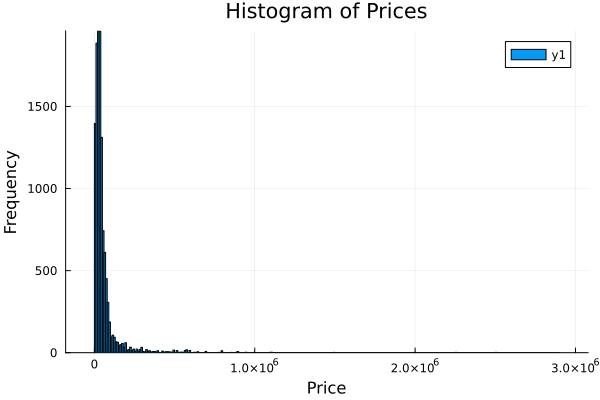

In [16]:
histogram(data.Prix, bins=300, xlabel="Price", ylabel="Frequency", title="Histogram of Prices")

Nous avons décidé d'entraîner nos modèles de régression linéaire sur un ensemble restreint suivant une logique simple. En effet, nous avons choisi de ne pas inclure les bateaux ayant un prix supérieur à 100 000$. Cette décision est motivée par le besoin de respecter la logique implémentée par notre fonction de perte, le RMSLE. Comme mentionné précédemment, ce calcul d'erreur pénalise plus fortement les prédictions qui sont supérieures aux valeurs réelles. Donc, en enlevant toutes les données démontrant a priori l'existence de bateaux ayant des prix plus élevés, nous réduisons notre probabilité de faire des prédictions au-dessus de la valeur réelle.

In [38]:
threshold = 100000  
replaced_value = size(train)[1] - sum(train.Prix .< threshold)

973

In [40]:

filtered_df = filter(row -> row.Prix < 100000, train);
df_high = filter(row -> row.Prix > 100000, train);

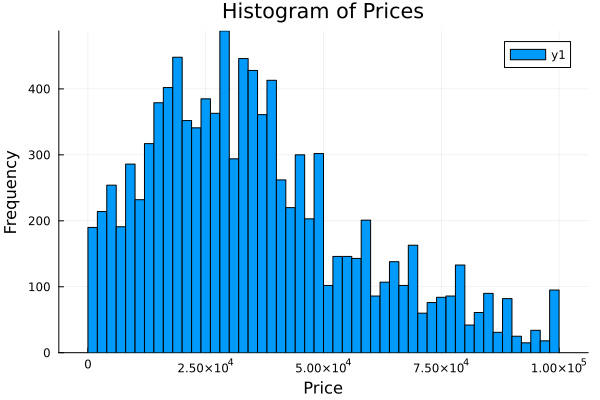

In [20]:
histogram(filtered_df.Prix, bins=75, xlabel="Price", ylabel="Frequency", title="Histogram of Prices")

Outre le prix, nous avons aussi remarqué que les mêmes manipulations pouvaient être appliquées à quelques variables explicatives. En effet, en enlevant environ 10% (dépendant de l'étude exploratoire) des valeurs les plus élevées de l'ensemble d'entraînement, notre modèle devenait beaucoup plus conservatif dans ses prédictions, ce qui nous permettait de réduire notre RMSLE.

In [64]:
filtered_df = filter(row -> row.Longueur > 10, filtered_df);
filtered_df = filter(row -> row.Longueur < 100, filtered_df);

In [ ]:
# data.Puissance_Moteur = ifelse.(data.Type .== "unpowered", 0, data.Puissance_Moteur);
# data_puissance = dropmissing(data, :Puissance_Moteur);
# data_puissance = filter(row -> row.Longueur > 10, data_puissance);
# model_puissance = lm(@formula(Puissance_Moteur ~ Longueur + Type), data_puissance)



In [80]:
# # Grouping by boat model and calculating mean price
# merged_df = combine(groupby(train, :Modèle), :Prix => mean => :Mean_Price)

# # Sort the DataFrame by mean price
# sorted_df = sort(merged_df, :Mean_Price, rev=true);
# #println(merged_df)

# price_ranges = [
#     ("Under5k", 0, 5000),
#     ("5kto10k", 5001, 10000),
#     ("10kto15k", 10001, 15000),
#     ("15kto20k", 15001, 20000),
#     ("20kto25k", 20001, 25000),
#     ("25kto30k", 25001, 30000),
#     ("30kto35k", 30001, 35000),
#     ("35kto40k", 35001, 40000),
#     ("40kto45k", 40001, 45000),
#     ("45kto50k", 45001, 50000),
#     ("50kto55k", 50001, 55000),
#     ("55kto60k", 55001, 60000),
#     ("60kto65k", 60001, 65000),
#     ("65kto70k", 65001, 70000),
#     ("70kto75k", 70001, 75000),
#     ("75kto80k", 75001, 80000),
#     ("80kto85k", 80001, 85000),
#     ("85kto90k", 85001, 90000),
#     ("90kto95k", 90001, 95000),
#     ("95kto100k", 95001, 100000)
# ]

# # Function to assign category based on price
# function assign_category(price)
#     for (category, min_price, max_price) in price_ranges
#         if price >= min_price && price <= max_price
#             return category
#         end
#     end
# end

# # Apply function to assign category to each model
category_mapping = DataFrame(Model = merged_df.Modèle, Category = map(assign_category, merged_df.Mean_Price));
     

In [81]:
group_counts = combine(groupby(category_mapping, :Category), nrow => :Count)
max_group = argmax(group_counts.Count)
max_Category = group_counts.Category[max_group]

In [82]:
function encode_category_Model!(df::DataFrame, category_mapping::DataFrame, model_col::Symbol)
    # Initialize binary columns
    categories = unique(category_mapping.Category)
    for category in categories
        df[!, Symbol("is", category)] = zeros(Int, nrow(df))
    end

    # Iterate over each row in the DataFrame
    for i in 1:nrow(df)
        model = df[i, model_col]
        matching_rows = filter(row -> row.Model == model, category_mapping)
        
        # If no matching rows found, treat as "Autre"
        if isempty(matching_rows)
            # category = get(category_mapping[category_mapping.Model .== "Autre", :Category], 1, "Autre")
            category = max_Category
        else
            category = matching_rows[1, :Category]
        end
        
        # Update the corresponding binary column
        df[i, Symbol("is", category)] = 1
    end
end

# train

missing_count = count(ismissing, train[!, :Modèle])
missing_count = count(ismissing, valid[!, :Modèle])

0

In [86]:
encode_category_Model!(train, category_mapping, :Modèle)
encode_category_Model!(valid, category_mapping, :Modèle)

LoadError: TypeError: non-boolean (Missing) used in boolean context

Les variables explicatives utilisées dans ce modèle ont été choisies selon la puissance de leur relation avec le prix (démontrée par la matrice de corrélation au début de l'étude exploratoire), en combinaison avec une division catégorielle des prix puisque celle-ci nous permettait une meilleure interprétabilité des coefficients. De plus, cette catégorisation a permis au modèle de réduire la variabilité puisque chaque groupe détient des caractéristiques plus distinctes pour chaque tranche de prix.

In [57]:
model = lm(@formula(Prix ~ ((isUnder5k + is5kto10k + is10kto15k + is15kto20k + 
        is20kto25k + is25kto30k + is30kto35k + 
        is35kto40k + is40kto45k + is45kto50k + is50kto55k + 
        is55kto60k + is60kto65k + is65kto70k + is70kto75k +
        is75kto80k + is80kto85k + is85kto90k + is90kto95k)*(Puissance_Moteur + Longueur))
        ), train)

LoadError: ArgumentError: There isn't a variable called 'isUnder5k' in your data; the nearest names appear to be: 

In [ ]:
# Prediction avec l'ensemble de validation
valid_prediction = predict(model, valid)
# Trouver la moyenne de prediction
mean_prediction = mean(valid_prediction)
# Remplacer les missing par la moyenne
valid_prediction = coalesce.(valid_prediction, mean_prediction)
# Transformer les predictions en valeur entiere
v = Int.(round.(valid_prediction, digits=0))
# Calculer le RMSLE
v = ifelse.(v.< 0, 0, v)
score = rmsle(v, valid.Prix)

## Régression bayesienne

In [ ]:
# Chargement des données
data = CSV.read("data/train.csv", DataFrame);

### Traitements des données qui sont missing
Pour la régression bayésienne avec rigde, nous avons seulement traité la longueur, la largeur, le poids, l'age, la puissance et le carburant.
Lorsque la variable est quantitative (Longueur, poids, ...) nous avons remplacé les missing par la valeur moyenne de cette variable.
Lorsque la variable est qualitative (carburant) nous avons remplacé les missing par le mode de cette variable.

In [ ]:
counts = combine(groupby(dropmissing(data), :Année), nrow => :count)
mode_Annee = counts[argmax(counts.count), :Année]
data.Annee = coalesce.(data.Année, mode_Annee);

In [ ]:
mean_longueur = mean(skipmissing(data.Longueur))
data.Longueur = coalesce.(data.Longueur, mean_longueur);

In [ ]:
mean_largeur = mean(skipmissing(data.Largeur))
data.Largeur = coalesce.(data.Largeur, mean_largeur);

In [ ]:
mean_poids = mean(skipmissing(data.Poids))
mean_poids = Int(round(mean_poids, digits=0))
data.Poids = coalesce.(data.Poids, mean_poids);

In [ ]:
counts = combine(groupby(dropmissing(data), :Carburant), nrow => :count)
mode_Carburant = counts[argmax(counts.count), :Carburant]
data.Carburant = coalesce.(data.Carburant, mode_Carburant);

In [ ]:
counts = combine(groupby(dropmissing(data), :Nombre_Moteurs), nrow => :count)
mode_Nombre_Moteurs = counts[argmax(counts.count), :Nombre_Moteurs]
data.Nombre_Moteurs = coalesce.(data.Nombre_Moteurs, mode_Nombre_Moteurs);

In [ ]:
mean_puissance = mean(skipmissing(data.Puissance_Moteur))
mean_puissance = Int(round(mean_puissance, digits=0))
data.Puissance_Moteur = coalesce.(data.Puissance_Moteur, mean_puissance);

In [ ]:
counts = combine(groupby(dropmissing(data), :Année_Vente), nrow => :count)
mode_Annee_Vente = counts[argmax(counts.count), :Année_Vente]
data.Année_Vente = coalesce.(data.Année_Vente, mode_Annee_Vente);

### Ajout de la variable de l'age

In [ ]:
data.Age = data.Année_Vente .- data.Année
data.Age = ifelse.(data.Age .< 0, 0, data.Age);

In [ ]:
Gadfly.plot(data, x=:Age, y=:Prix, Geom.point, Scale.y_log10)

Nous croyons qu'il existe une corrélation entre l'age d'un bateau et son prix.

### Ajout de la variable de la puissance

In [ ]:
data.Puissance = data.Puissance_Moteur .* data.Nombre_Moteurs;

In [ ]:
Gadfly.plot(data, x=:Puissance, y=:Prix, Geom.point, Scale.y_log10, Scale.x_log10)

Il semble y avoir une corrélation entre la puissance et le prix des embarcations.

### Séparation entre un ensemble d'entrainement et un ensemble de test

In [ ]:
Random.seed!(3302)

ntrain = round(Int, .8*nrow(data))

train_id = sample(1:nrow(data), ntrain, replace=false, ordered=true)
valid_id = setdiff(1:nrow(data), train_id)

train = data[train_id, :]
valid = data[valid_id, :];

### Standardisation des données

In [ ]:
function one_hot_encode(df::DataFrame, column_name::Symbol)
    unique_values = unique(df[!, column_name])
    for value in unique_values
        df[!, Symbol(value)] = ifelse.(df[!, column_name] .== value, 1, 0)
    end
    select!(df, Not(column_name))  # Supprimer la colonne d'origine
    return df
end

In [ ]:
X = select(train, Not([:Prix, :ID]))
X = select(X, [:Longueur, :Largeur, :Poids, :Age, :Puissance, :Carburant])
X = one_hot_encode(X, :Carburant)
Y = select(train, :Prix)

# Standardisation des variables
dt = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(X), dims=1)
X_std = StatsBase.transform(dt, Matrix{Float64}(X))

dt = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(Y), dims=1)
Y_std = StatsBase.transform(dt, Matrix{Float64}(Y));

### Estimation de λ

In [ ]:
X_valid = select(valid, Not([:Prix, :ID]))
X_valid = select(X_valid, [:Longueur, :Largeur, :Poids, :Age, :Puissance, :Carburant])
X_valid = one_hot_encode(X_valid, :Carburant)
Y_valid = select(valid, :Prix)

# Standardisation des variables
dtx = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(X_valid), dims=1)
X_std_valid = StatsBase.transform(dtx, Matrix{Float64}(X_valid))

dty = StatsBase.fit(StatsBase.ZScoreTransform, Matrix{Float64}(Y_valid), dims=1)
Y_std_valid = StatsBase.transform(dty, Matrix{Float64}(Y_valid));

In [ ]:
df = DataFrame(λ = Float64[], Rmsle = Float64[])
y_validation = StatsBase.reconstruct(dty, Y_std_valid)
y_validation = round.(Int, y_validation)

for λ = 3700:0.001:3710
    β̂ = (X_std'X_std + λ*I)\X_std'Y_std  # on fait la régression pour trouver les coefs.
    
    ŷ = X_std_valid*β̂  # on fait une prédiction (comme avant) avec les données de test
    y_pred = StatsBase.reconstruct(dty, ŷ)
    y_pred = round.(Int, y_pred)
    y_pred = abs.(y_pred)
   
    
    Rmsle = rmsle(y_pred[:, 1], y_validation[:, 1])  # on calcul le rmse (avec StatsBase...)
    
    push!(df, [λ, Rmsle])  # maintenant, il faut stocker ces résultats dans notre dataframe :
end

In [ ]:
λ̂ = df.λ[argmin(df.Rmsle)]

In [ ]:
Gadfly.plot(df, x=:λ, y=:Rmsle, Geom.line)

### Calcul du RMSLE

In [ ]:
β̂ = (X_std'X_std + λ̂ *I)\X_std'Y_std

ŷ = X_std_valid*β̂ 
y_pred = StatsBase.reconstruct(dty, ŷ)
y_pred = round.(Int, y_pred)
y_pred = abs.(y_pred)
y_validation = StatsBase.reconstruct(dty, Y_std_valid)
y_validation = round.(Int, y_validation)
score = rmsle(y_pred[:, 1], y_validation[:, 1])
println("Le rmsle obtenu est de: ", score)

Pour la régression de ridge, nous avons obtenu un rmsle de 0.8536. Lorsque nous avons mis notre prédiction sur kaggle, nous pensions que nous allions un score un peu meilleur que 0.8536 puisque le modèle que nous avons fait allait avoir toutes les données d'entrainement. Surprenament, nous avons obtenu un score de 2.63777. Nous croyons que cette différence est dûe à la restandardisation de la prédiction de nos prix.

## Approche de Régression linéaire par traitement de language naturel

In [ ]:
Random.seed!(3302)
train_id = sample(1:nrow(full_train), round(Int, .8nrow(full_train)), ordered=true, replace=false)
valid_id = setdiff(1:nrow(full_train), train_id)

train = full_train[train_id,:]
valid = full_train[valid_id,:];

In [ ]:
regex_pattern = r"\D+"
function extract_model_name(model)
    match_result = match(regex_pattern, replace(lowercase(string(model)), r"\s+" => ""))
    return match_result === nothing ? "other" : match_result.match
end

train[!, :Simplified_Modèle] = coalesce.(extract_model_name.(train[!, :Modèle]), "o")
valid[!, :Simplified_Modèle] = coalesce.(extract_model_name.(valid[!, :Modèle]), "o");

train[!, :Simplified_Fabricant] = coalesce.(extract_model_name.(train[!, :Fabricant]), "a")
valid[!, :Simplified_Fabricant] = coalesce.(extract_model_name.(valid[!, :Fabricant]), "a");


In [ ]:
train[!, :Fab_Model_Longueur] = train[!, :Simplified_Fabricant] .* "_" .* train[!, :Simplified_Modèle] .* "_" .*  train[!, :Condition] .* "_" .* string.(train[!, :Longueur]) .* "_" .* string.(train[!, :Poids]) .* "_" .*  string.(train[!, :Année]) .* "_" .* string.(train[!, :Puissance_Moteur]) .* "_" .* string.(train[!, :Type])
valid[!, :Fab_Model_Longueur] = valid[!, :Simplified_Fabricant] .* "_" .* valid[!, :Simplified_Modèle] .* "_" .*  valid[!, :Condition] .* "_" .* string.(valid[!, :Longueur]) .* "_" .* string.(valid[!, :Poids]) .* "_" .*  string.(valid[!, :Année]) .* "_" .* string.(valid[!, :Puissance_Moteur]) .* "_" .* string.(valid[!, :Type]);
unique_data_modèles = unique(train[!, :Fab_Model_Longueur])
unique_valid_modèles = unique(valid[!, :Fab_Model_Longueur]);

In [ ]:
using StringDistances

threshold = 0.2
mapping = Dict{String, String}()

for modèle_valid in unique_valid_modèles
    best_match = ""
    best_similarity = 0.0
    
    for modèle_train in unique_data_modèles
        similarity = compare(modèle_valid, modèle_train, StringDistances.Levenshtein())
        
        if similarity > threshold && similarity > best_similarity
            best_match = modèle_train
            best_similarity = similarity
        end
    end
    
    if best_match != ""
        mapping[modèle_valid] = best_match
    end
end

In [ ]:
replace_with_mapping(value) = get(mapping, value, value)
valid[!, :Fab_Model_Longueur] .= replace_with_mapping.(valid[!, :Fab_Model_Longueur]);


In [ ]:
model = lm(@formula(Prix ~ ((Fab_Model_Longueur))), train);


In [ ]:
valid_prediction = predict(model, valid)
mean_prediction = mean(valid_prediction)
valid_prediction = coalesce.(valid_prediction, mean_prediction)
v = Int.(round.(valid_prediction, digits=0))
v = ifelse.(v.< 0, 0, v)
score = rmsle(v, valid.Prix)

## Analyse par composantes principales

In [ ]:
## Chargement des données
data = CSV.read("data/train.csv", DataFrame);

### Traitements des données qui sont missing
Pour l'analyse en composantes principales, nous avons seulement traité le nombre de moteurs, le poids, la puissance des moteurs, la longueur et la largeur.
Lorsque la variable est quantitative (Longueur, poids, ...) nous avons remplacé les missing par la valeur moyenne de cette variable.
Lorsque la variable est quanlitative (nombre de moteur) nous avons remplacé les missing par le mode de cette variable.

In [ ]:
mode = sort(combine(groupby(dropmissing(data, :Nombre_Moteurs), :Nombre_Moteurs), nrow => :Occurence), :Occurence, rev=true).Nombre_Moteurs[1]
data.Nombre_Moteurs = coalesce.(data.Nombre_Moteurs, mode);

In [ ]:
mean_poids = mean(skipmissing(data.Poids))
data.Poids = coalesce.(data.Poids, mean_poids);

In [ ]:
mean_puissance = mean(skipmissing(data.Puissance_Moteur))
data.Puissance_Moteur = coalesce.(data.Puissance_Moteur, mean_puissance);

In [ ]:
mean_longueur = mean(skipmissing(data.Longueur))
data.Longueur = coalesce.(data.Longueur, mean_longueur);

In [ ]:
mean_largeur = mean(skipmissing(data.Largeur))
data.Largeur = coalesce.(data.Largeur, mean_largeur);

### Pour le traitement des variables qualitatives, nous avons fait un one hot encoding

In [ ]:
function one_hot_encode(df::DataFrame, categories::Vector{T}, nom_col::Symbol) where T
    one_hot_matrix = zeros(Int, size(df, 1), length(categories))
    for (i, cat) in enumerate(categories)
        one_hot_matrix[:, i] .= ifelse.(df[!, nom_col] .== cat, 1, 0)
    end
    return DataFrame(one_hot_matrix, Symbol.("one_hot_", categories, "_", nom_col))
end

In [ ]:
# Sélection des variable d'intérêt
select!(data, [:Prix, :Longueur, :Largeur, :Nombre_Moteurs, :Poids, :Puissance_Moteur]);

In [ ]:
categories_Classe = unique(data.Nombre_Moteurs)
temp = one_hot_encode(data, categories_Classe, :Nombre_Moteurs)
data = hcat(data, temp)
select!(data, Not(:Nombre_Moteurs));

### Séparation en un ensemble d'entrainement et un ensemble de validation

In [ ]:
Random.seed!(3302)
train_id = sample(1:nrow(data), round(Int, .8*nrow(data)), ordered=true, replace=false)
valid_id = setdiff(1:nrow(data), train_id)

train = data[train_id, :]
valid = data[valid_id,:];

### Modèle par l'analyse en composante principale

In [ ]:
# Variable cible
y = train[:, :Prix];

In [ ]:
# Variables explicatives
select!(train, Not(:Prix));
X = Matrix{Float64}(train);

In [ ]:
# Appliquer l'ACP pour réduire la dimensionnalité
pca_model = fit(PCA, X, maxoutdim=8)

Yte = predict(pca_model, X)
Xr = reconstruct(pca_model, Yte)

# Construire un modèle de prédiction (par exemple, régression linéaire)
model = lm(Xr, y)

In [ ]:
prix = valid.Prix
select!(valid, Not(:Prix));
X_valid = Matrix{Float64}(valid);

In [ ]:
# Prediction avec l'ensemble de validation
valid_prediction = predict(model, X_valid)

# Transformer les predictions en valeur entiere
v = Int.(round.(valid_prediction, digits=0))

for i in 1:length(v)
    if v[i] < 0
        v[i] = 0
    end
end

# Calculer le RMSLE
score = rmsle(v, prix)
println("Le rmsle obtenu est de: ", score)

Nous avons fait de nombreux essais avec l'analyse en composante principale, mais nous n'avons jamais réussi à avoir un meilleur rmsle de 0.96. Ainsi, nous avons fini par abandonner ce modèle.

# Présentation des méthodes d'entrainement et validations

## Validation croisée par k-fold

# 4. Modèle final pour la sousmission Kaggle

### Après tous nos tests de modèles différents, nous avons déterminé que le meilleur modèle est le ...
